In [163]:
import ast
import json
import utils
import piezo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from catomatic.CatalogueBuilder import BuildCatalogue
from catomatic.Ecoff import GenerateEcoff

%load_ext autoreload
%autoreload 2
plt.rcParams['figure.dpi']=150


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using a binomial hypothesis test to generate catalogues

## Import data

In [164]:
bdq_mutations = pd.read_csv('../data/ignore/MUTATIONS_BDQ.csv').reset_index()
bdq_genomes = pd.read_csv('../../BDQ_analysis/tb-bdq-cat/data/GENOMES.csv.gz').reset_index()
bdq_phenotypes = pd.read_csv('../data/ignore/phenotypes_bdq.csv').reset_index()

#read in wildcards for piezo catalogues
with open('../../BDQ_analysis/tb-bdq-cat/wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)


## Data Prep 

In [165]:
#create mutations columns with garc grammar
bdq_mutations['MUTATION'] = bdq_mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)

In [166]:
#remove sysnonymous mutations
bdq_mutations = bdq_mutations[bdq_mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] != x.split("@")[-1][-1]
)]
#remove null calls
bdq_mutations = bdq_mutations[bdq_mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1] not in ['Z', 'z']
)]
#populate major alleles
bdq_mutations["FRS"] = bdq_mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
#filter for high quality phenotypes only
phenotypes_cryptic = bdq_phenotypes[bdq_phenotypes.QUALITY=='HIGH']

#create samples table - one row per sample 
bdq_samples = pd.merge(bdq_phenotypes, bdq_genomes, how='inner', on=['UNIQUEID']).rename(columns={'METHOD_MIC':'MIC'})[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "MIC"]]

#remove superfluous columns
bdq_mutations = bdq_mutations[['UNIQUEID', 'GENE', 'MUTATION', 'FRS']]
bdq_samples = bdq_samples [['UNIQUEID', 'METHOD_3', 'PHENOTYPE', 'MIC']]


In [167]:
bdq_mutations

,UNIQUEID,GENE,MUTATION,FRS
0,site.01.subj.DR0689.lab.DR0689.iso.1,pepQ,pepQ@R86L,1.000
1,site.01.subj.DR0011.lab.DR0011.iso.1,Rv0678,Rv0678@c-11a,1.000
2,site.01.subj.DR0602.lab.DR0602.iso.1,Rv0678,Rv0678@c-11a,1.000
3,site.01.subj.DR0617.lab.DR0617.iso.1,pepQ,pepQ@V238M,1.000
4,site.01.subj.DR0650.lab.DR0650.iso.1,Rv0678,Rv0678@R50Q,1.000
...,...,...,...,...
5942,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,atpE,atpE@12_ins_c,0.317
5943,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,atpE,atpE@1_mixed,0.385
5944,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,atpE,atpE@234_del_a,0.179
5945,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,atpE,atpE@239_del_tcaa,0.179


In [168]:
bdq_samples

,UNIQUEID,METHOD_3,PHENOTYPE,MIC
0,site.02.subj.0002.lab.2014222005.iso.1,UKMYC5,S,0.06
1,site.02.subj.0004.lab.2014222010.iso.1,UKMYC5,S,0.06
2,site.02.subj.0006.lab.2014222013.iso.1,UKMYC5,S,0.25
3,site.02.subj.0007.lab.2014222016.iso.1,UKMYC5,S,0.06
4,site.02.subj.0008.lab.2014222017.iso.1,UKMYC5,S,0.06
...,...,...,...,...
11862,site.10.subj.YA00205997.lab.YA00205997.iso.1,MGIT960,R,2
11863,site.10.subj.YA00206179.lab.YA00206179.iso.1,MGIT960,R,NaN
11864,site.10.subj.YA00206790.lab.YA00206790.iso.1,MGIT960,R,NaN
11865,site.10.subj.YA00214934.lab.YA00214934.iso.1,MGIT960,R,NaN


## Build the catalogue

In [169]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, test='Binomial', background=0.1, p=0.95, strict_unlock=True)
catalogue.return_catalogue()

{'Rv0678@A101E': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
    'p_value': 1.0,
    'contingency': [[0, 1], [193, 10440]]},)},
 'Rv0678@S68N': {'pred': 'U',
  'evid': ({'proportion': 1.0,
    'confidence': (np.float64(0.20654931437723742), np.float64(1.0)),
    'p_value': np.float64(0.1),
    'contingency': [[1, 0], [193, 10440]]},)},
 'Rv0678@Q51R': {'pred': 'U',
  'evid': ({'proportion': 0.3333333333333333,
    'confidence': (np.float64(0.061491944720396215),
     np.float64(0.7923403991979523)),
    'p_value': np.float64(0.271),
    'contingency': [[1, 2], [193, 10440]]},)},
 'Rv0678@G103S': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (np.float64(0.0), np.float64(0.6576197724933469)),
    'p_value': 1.0,
    'contingency': [[0, 2], [193, 10440]]},)},
 'Rv0678@A62T': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
    'p_value': 1

In [170]:
_catalogue = catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)
_catalogue

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
275,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,Rv0678@*=,S,{},"{""default_rule"": ""True""}",{}
281,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,pepQ@*=,S,{},"{""default_rule"": ""True""}",{}
287,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,mmpS5@*=,S,{},"{""default_rule"": ""True""}",{}
293,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,mmpL5@*=,S,{},"{""default_rule"": ""True""}",{}
299,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,atpE@*=,S,{},"{""default_rule"": ""True""}",{}
...,...,...,...,...,...,...,...,...,...,...,...
300,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
301,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
302,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
303,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:482: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:485: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


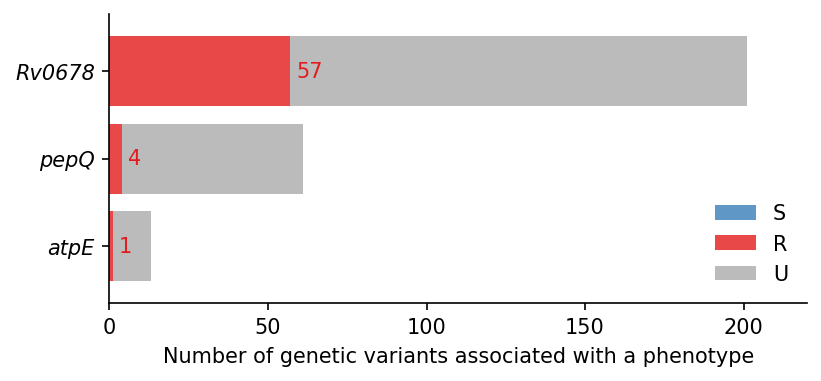

In [171]:
_catalogue = _catalogue[_catalogue['EVIDENCE'].apply(lambda x: not any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]

utils.plot_catalogue_counts(_catalogue)


## Statistical Tests and parameters

/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:485: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


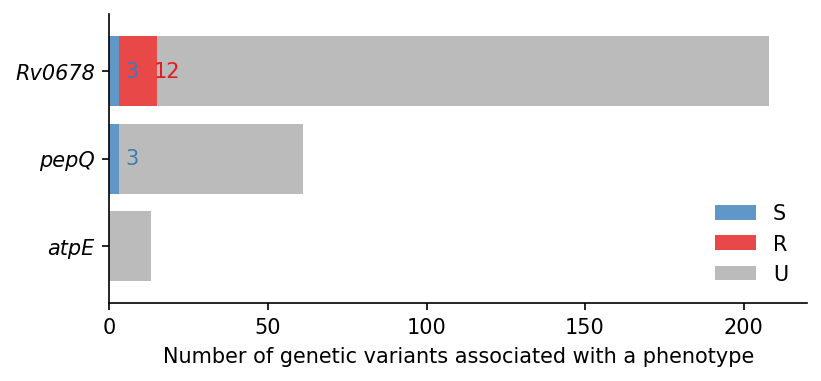

In [172]:
#increase background rate to 0.5
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, background=0.5, test='Binomial', p=0.95, strict_unlock=True)
#generate piezo-compatible catalogue
_catalogue = catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)
#remove seeds and wildcards
_catalogue = _catalogue[_catalogue['EVIDENCE'].apply(lambda x: not any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]
#count phentoypes
utils.plot_catalogue_counts(_catalogue)


/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:485: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


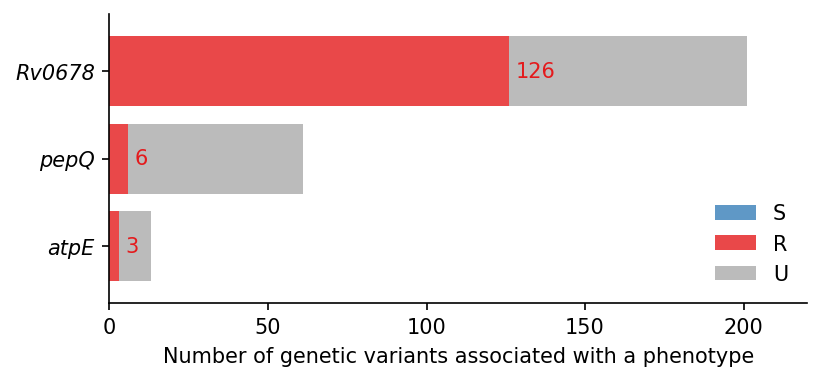

In [173]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, test='Fisher', p=0.95, strict_unlock=True)
#generate piezo-compatible catalogue
_catalogue = catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)
#remove seeds and wildcards
_catalogue = _catalogue[_catalogue['EVIDENCE'].apply(lambda x: not any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]
#count phentoypes
utils.plot_catalogue_counts(_catalogue)



## Seeding the catalogue

Pre-specified variants can be added prior to running the alogirthm

In [174]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, seed=['gene@A1A', 'gene@B2B'], test='Binomial', background=0.05, p=0.95)
catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)[:5]

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,gene@A1A,S,{},"{""seeded"": ""True""}",{}
1,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,gene@B2B,S,{},"{""seeded"": ""True""}",{}
2,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,Rv0678@A101E,S,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.793...",{}
3,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,Rv0678@G103S,S,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.657...",{}
4,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,Rv0678@A62T,S,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.793...",{}


## Post-hoc updates

### Simply adding rules

In [175]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, test='Binomial', background=0.05, p=0.95)

In [176]:
# add rule to catalogue
catalogue.update({'gene@A1A':'R'})

_catalogue = catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)
_catalogue[_catalogue.MUTATION=='gene@A1A']

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
277,NC_000962.3,DEMO,0.1.1,GARC1,RUS,BDQ,gene@A1A,R,{},{},{}


### Adding rules with replacement

In [177]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, test='Binomial', background=0.1, p=0.95, strict_unlock=True)

In [178]:
#add rule with replacement
catalogue = catalogue.update({'Rv0678@*_indel':'R'}, replace=True, wildcards=piezo_wildcards)

#generate piezo-compatible catalogue
_catalogue = catalogue.build_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards)
#remove seeds and wildcards
_catalogue = _catalogue[_catalogue['EVIDENCE'].apply(lambda x: not any(key in ast.literal_eval(x) for key in ['seeded', 'default_rule']))]
#count phentoypes
_catalogue.PREDICTION.value_counts()

{'Rv0678@A101E': {'pred': 'U', 'evid': ({'proportion': 0.0, 'confidence': (np.float64(0.0), np.float64(0.7934506856227626)), 'p_value': 1.0, 'contingency': [[0, 1], [193, 10440]]},)}, 'Rv0678@S68N': {'pred': 'U', 'evid': ({'proportion': 1.0, 'confidence': (np.float64(0.20654931437723742), np.float64(1.0)), 'p_value': np.float64(0.1), 'contingency': [[1, 0], [193, 10440]]},)}, 'Rv0678@Q51R': {'pred': 'U', 'evid': ({'proportion': 0.3333333333333333, 'confidence': (np.float64(0.061491944720396215), np.float64(0.7923403991979523)), 'p_value': np.float64(0.271), 'contingency': [[1, 2], [193, 10440]]},)}, 'Rv0678@G103S': {'pred': 'U', 'evid': ({'proportion': 0.0, 'confidence': (np.float64(0.0), np.float64(0.6576197724933469)), 'p_value': 1.0, 'contingency': [[0, 2], [193, 10440]]},)}, 'Rv0678@A62T': {'pred': 'U', 'evid': ({'proportion': 0.0, 'confidence': (np.float64(0.0), np.float64(0.7934506856227626)), 'p_value': 1.0, 'contingency': [[0, 1], [193, 10440]]},)}, 'Rv0678@192_ins_g': {'pred':

PREDICTION
U    168
R     36
S      0
Name: count, dtype: int64

## The benefits of a piezo-parsable catalogue

[[  576   193    97]
 [  165 10440   396]]
Catalogue coverage of isolates: 0.9584562231397994
Sensitivity: 0.7490247074122237
Specificity: 0.9844413012729845


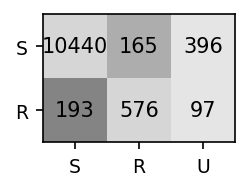

In [179]:
catalogue = BuildCatalogue(samples=bdq_samples, mutations=bdq_mutations, test='Binomial', background=0.1, p=0.95, strict_unlock=True)
#export piezo comatible format
catalogue.to_piezo(genbank_ref="NC_000962.3", catalogue_name="DEMO", version='0.1.1', drug="BDQ", wildcards=piezo_wildcards, outfile='./catalogue.csv')

#test catalogue on entire dataset using piezo
test_set = pd.merge(bdq_samples, bdq_mutations, how='left', on=['UNIQUEID'])

#predict phenotypes for test set
cm, _cov, _sens_75, _spec_75, _FN_ids, _FP_ids = utils.piezo_predict(test_set, f"./catalogue.csv", "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])
utils.plot_truthtables(df_cm, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc"])

## The benefits of an algorithmic approach 

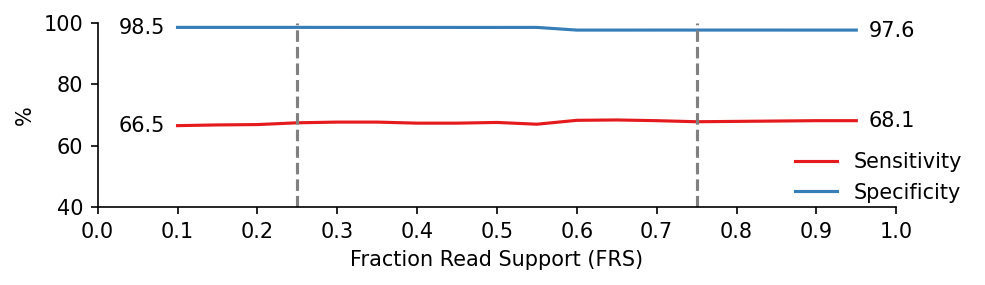

In [180]:
results = []

for i in np.arange(0.1, 1, 0.05):
    # Build and save catalogue across FRS range
    catalogue_name = f"BDQ-{int(i*100)}-2024.11"
    csv_path = f"./temp/catalogue_{int(i*100)}.csv"
    
    catalogue =  BuildCatalogue(bdq_samples, bdq_mutations, FRS=i, test='Binomial', tails='two', strict_unlock=True, background=0.1)
    catalogue.to_piezo("NC_000962.3", catalogue_name, "1.1", "BDQ", piezo_wildcards, outfile=f"./temp/catalogue_{int(i*100)}.csv")
    
    # Predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids, _FP_ids = utils.piezo_predict(
        test_set, 
        csv_path, 
        "BDQ", 
        Print=False, 
        U_to_S=True
    )
    
    results.append((i, _sens * 100, _spec * 100, _cov * 100, _FN_ids))

# Create DataFrame
data = pd.DataFrame(results, columns=["FRS", "Sensitivity", "Specificity", "Coverage", "FNs"])

utils.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False)

# ECOFF Generator

In [181]:
#filter NaNs
ukmyc_samples = bdq_samples[(bdq_samples.METHOD_3.isin(['UKMYC5','UKMYC6']))&(~bdq_samples.MIC.isna())]

In [182]:
ukmyc_samples

,UNIQUEID,METHOD_3,PHENOTYPE,MIC
0,site.02.subj.0002.lab.2014222005.iso.1,UKMYC5,S,0.06
1,site.02.subj.0004.lab.2014222010.iso.1,UKMYC5,S,0.06
2,site.02.subj.0006.lab.2014222013.iso.1,UKMYC5,S,0.25
3,site.02.subj.0007.lab.2014222016.iso.1,UKMYC5,S,0.06
4,site.02.subj.0008.lab.2014222017.iso.1,UKMYC5,S,0.06
...,...,...,...,...
10699,site.10.subj.YA00196292.lab.YA00196292.iso.1,UKMYC6,S,0.06
10700,site.10.subj.YA00196851.lab.YA00196851.iso.1,UKMYC6,S,0.06
10701,site.10.subj.YA00197623.lab.YA00197623.iso.1,UKMYC6,S,0.12
10702,site.10.subj.YA00197630.lab.YA00197630.iso.1,UKMYC6,S,0.06


In [183]:
init_obj = GenerateEcoff(ukmyc_samples, bdq_mutations, censored=True)
ecoff, z_99, mu, sigma_hat, model = init_obj.generate()
print ('ECOFF:', ecoff)

ECOFF: 0.12129785652796624


/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  wt_densities = [count / (total_wt * width) for count, width in zip(wt_mic_counts, wt_widths)]


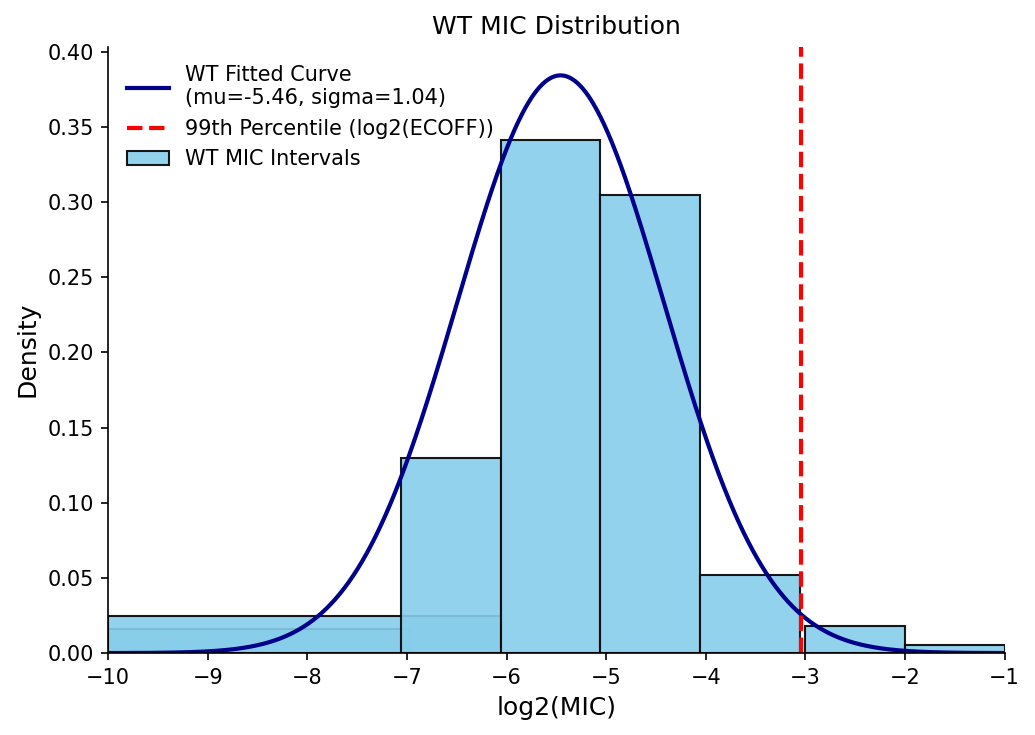

In [184]:
y_low, y_high = init_obj.define_intervals(init_obj.df)
utils.plot_ecoff_distributions(y_low, y_high, mu, sigma_hat, z_99, -10, -1)

# Using interval regression to build MIC catalogues

In [185]:
from intreg.meintreg import MeIntReg
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from autograd.scipy.stats import norm  # Autograd-compatible normal distribution functions
from scipy.optimize import minimize
import matplotlib.pyplot as plt

bdq_mutations = pd.read_csv('../data/ignore/MUTATIONS_BDQ.csv').reset_index()
bdq_genomes = pd.read_csv('../../BDQ_analysis/tb-bdq-cat/data/GENOMES.csv.gz').reset_index()
bdq_phenotypes = pd.read_csv('../data/ignore/phenotypes_bdq.csv').reset_index()

#create mutations columns with garc grammar
bdq_mutations['MUTATION'] = bdq_mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)

#remove sysnonymous mutations
bdq_mutations = bdq_mutations[bdq_mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] != x.split("@")[-1][-1]
)]
#remove null calls
bdq_mutations = bdq_mutations[bdq_mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1] not in ['Z', 'z']
)]
#populate major alleles
bdq_mutations["FRS"] = bdq_mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
#filter for high quality phenotypes only
phenotypes_cryptic = bdq_phenotypes[bdq_phenotypes.QUALITY=='HIGH']

#create samples table - one row per sample 
bdq_samples = pd.merge(bdq_phenotypes, bdq_genomes, how='inner', on=['UNIQUEID']).rename(columns={'METHOD_MIC':'MIC'})


mgit_samples = bdq_samples[(bdq_samples.METHOD_3.isin(['MGIT960']))&(~bdq_samples.MIC.isna())]
mgit = pd.merge(mgit_samples, bdq_mutations, how='left', on=['UNIQUEID'])

In [186]:
def process_mic_data(df):
    y_low = []
    y_high = []

    dilution_factor = 2
    tail_dilution_factor = dilution_factor ** 3 #3 doubling dilutions (or 3 log2MICs) censored extension on either side

    for mic in df['MIC']:
        if mic.startswith('<='):
            lower_bound = float(mic[2:])
            y_low.append(lower_bound / tail_dilution_factor)  # Adjust for left-censoring
            y_high.append(lower_bound)
        elif mic.startswith('>'):
            upper_bound = float(mic[1:])
            y_low.append(upper_bound)
            y_high.append(upper_bound * tail_dilution_factor)  # Adjust for right-censoring
        else:
            # For exact MIC values, the interval is MIC - 1 doubling dilution
            mic_value = float(mic)
            y_low.append(mic_value / dilution_factor)
            y_high.append(mic_value)
            
    return np.round(np.array(y_low), 3), np.round(np.array(y_high), 3)

def build_X(df):
    
    # Get all unique IDs from the input DataFrame
    unique_ids = df['UNIQUEID'].unique()

    mut_matrix = pd.pivot_table(
        df,
        index="UNIQUEID",
        columns="MUTATION",
        aggfunc="size",  # counts occurrences
        fill_value=0,    # absence of the mutation
    )

    mut_matrix = mut_matrix.applymap(lambda x: 1 if x > 0 else 0)
    #reindex the matrix to ensure all unique IDs are present, even if they have no mutations
    mut_matrix = mut_matrix.reindex(unique_ids, fill_value=0)

    return mut_matrix

def cluster_coordinates(mutations_df, samples_df, distance):

    all_mutations = mutations_df
    
    all_mutations.dropna(subset="ALT", inplace=True)
    all_mutations["SNP_ID"] = (
        all_mutations["GENE"]
        + "_"
        + all_mutations["GENE_POSITION"].astype(str)
        + "_"
        + all_mutations["REF"]
        + "_"
        + all_mutations["ALT"]
    )

    # Build the SNP matrix (binary matrix where 1 = mutation, 0 = no mutation)
    snp_matrix = pd.pivot_table(
        all_mutations,
        index="UNIQUEID",
        columns="SNP_ID",
        aggfunc="size",
        fill_value=0
    )

    snp_matrix = snp_matrix.applymap(lambda x: 1 if x > 0 else 0)

    # Include all UNIQUEIDs from the original dataset (to ensure WT samples are included)
    unique_ids = samples_df["UNIQUEID"].unique()
    snp_matrix = snp_matrix.reindex(unique_ids, fill_value=0)

    # Calculate pairwise distances (Hamming distance)
    dist_matrix = pairwise_distances(snp_matrix, metric='hamming')

    # Perform Agglomerative Clustering on the distance matrix
    agg_cluster = AgglomerativeClustering(
        metric='precomputed',
        linkage='complete',
        distance_threshold=distance/len(snp_matrix.columns),  # Hamming threshold conversion
        n_clusters=None
    )

    # Cluster IDs for samples with mutations
    cluster_ids = agg_cluster.fit_predict(dist_matrix)

    return cluster_ids

def predicted_effects(result, X, p):
    # Extract only the first p elements of the result, which correspond to the mutation effects
    fixed_effects_coefficients = result.x[:p]

    # Sigma (standard deviation)
    sigma = result.x[-1]

    # Create DataFrame for mutation effects
    mutation_effects = pd.DataFrame({
        'Mutation': X.columns,  # The names of the mutations from X
        'Effect_Size': fixed_effects_coefficients
    })

    # Convert effect sizes to MIC values (by reversing the log transformation)
    mutation_effects['MIC'] = 2**mutation_effects['Effect_Size']

    if hasattr(result, 'hess_inv'):
        hess_inv_dense = result.hess_inv.todense()  # Convert to a dense matrix
        # Extract the diagonal elements corresponding to the fixed effects (log2(MIC) scale)
        effect_std_log2 = np.sqrt(np.diag(hess_inv_dense)[:p])  # Standard deviation of log2(MIC)
        mutation_effects['Effect_Std'] = effect_std_log2
        # Convert standard deviation to MIC scale
        mutation_effects['MIC_Std'] = mutation_effects['MIC'] * np.log(2) * mutation_effects['Effect_Std']
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'Effect_Std', 'MIC', 'MIC_Std']]
    else:
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'MIC']]

    return mutation_effects

def log_likelihood_mixed_effects(params, y_low, y_high, X, clusters):
    beta = params[:X.shape[1]]  # Fixed effects
    u = params[X.shape[1]:-1]  # Random effects for clusters
    sigma = params[-1]  # Standard deviation

    # Predicted mean for each sample
    mu = np.dot(X, beta) + u[clusters]  # Use cluster numeric IDs for random effects

    log_L = 0

    # Likelihood for left-censored values
    left_censored = y_low == -5.96578428
    if np.any(left_censored):
        log_L += np.sum(norm.logcdf((y_high[left_censored] - mu[left_censored]) / sigma))

    # Likelihood for right-censored values
    right_censored = (y_high == 4) | (y_high == 6)
    if np.any(right_censored):
        log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu[right_censored]) / sigma)))

    # Likelihood for interval-censored values
    interval_censored = ~left_censored & ~right_censored & (y_low != y_high)
    if np.any(interval_censored):
        log_L += np.sum(
            np.log(
                norm.cdf((y_high[interval_censored] - mu[interval_censored]) / sigma)
                - norm.cdf((y_low[interval_censored] - mu[interval_censored]) / sigma)
            )
        )

    return -log_L  # Minimize the negative log-likelihood

In [187]:
cluster_ids = cluster_coordinates(bdq_mutations, mgit_samples, distance=25)

X = build_X(mgit)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit_samples.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))

#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_38754/299923420.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  snp_matrix = snp_matrix.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_38754/299923420.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mut_matrix = mut_matrix.applymap(lambda x: 1 if x > 0 else 0)


In [188]:
np.random.seed(1)

result = minimize(
        log_likelihood_mixed_effects,
        initial_params,
        args=(y_low_log, y_high_log, X, cluster_ids),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100000, 'maxfun': 1000000, 'ftol': 1e-4, 'gtol': 1e-4}
    )

w_wt_bfgs = predicted_effects(result, X, p)


Text(0.5, 1.0, 'True MIC Distribution (log2) with Fitted Curves')

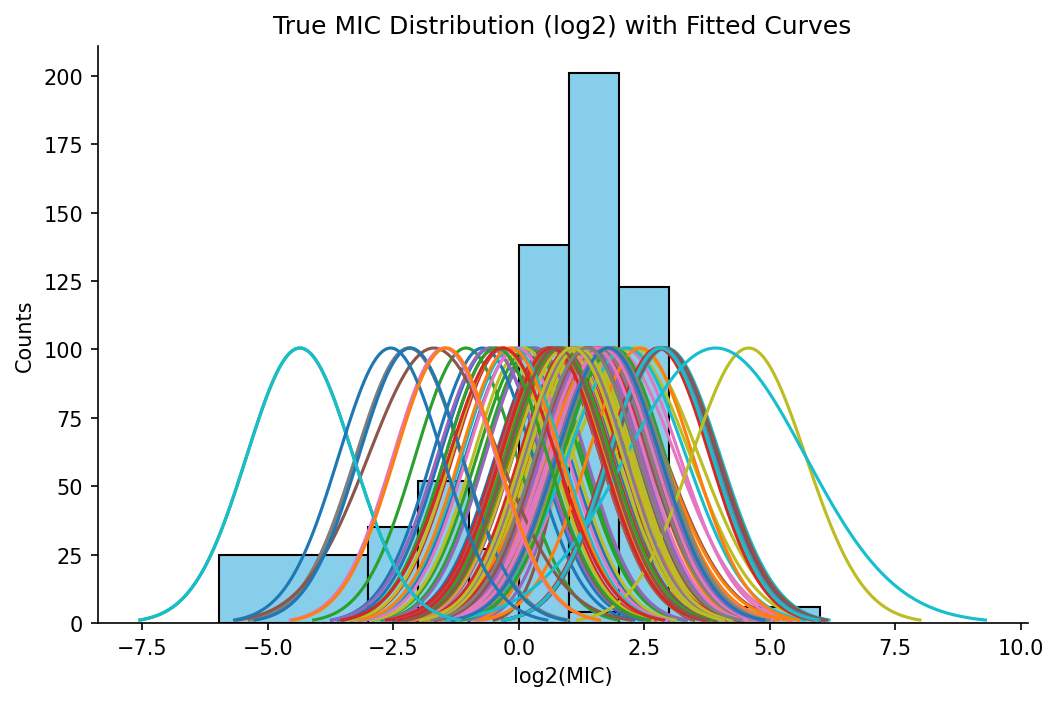

In [189]:
intervals = [(low, high) for low, high in zip(y_low_log, y_high_log)]
# Get unique intervals
unique_intervals = sorted(set(intervals))
# Calculate counts for each unique interval
mic_counts = [intervals.count(interval) for interval in unique_intervals]
# Extract the midpoints of the unique intervals for plotting
interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
# Extract widths for the bars (log2MIC range of each interval)
interval_widths = [high - low for low, high in unique_intervals]

plt.figure(figsize=(8, 5))
plt.bar(interval_midpoints, height=mic_counts, width=interval_widths,
        align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

for _, row in w_wt_bfgs.iterrows():
    effect_size = row['Effect_Size']  # This is the log2(MIC) mean from the model
    effect_std = row['Effect_Std']    # This is the log2(MIC) std from the model
    
    # Generate the x-values for the fitted curve (log2 scale)
    x_values = np.linspace(effect_size - 3*effect_std, effect_size + 3*effect_std, 100)
    
    # Generate the normal distribution using effect size and std (fitted mean and std)
    y_values = norm.pdf(x_values, loc=effect_size, scale=effect_std)
    
    # Scale the normal distribution to match the height of the histogram
    y_values *= (max(mic_counts) / max(y_values))/2
    
    plt.plot(x_values, y_values, label=f'Fitted {row["Mutation"]}', linestyle='-')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('log2(MIC)')
plt.ylabel('Counts')
plt.title('True MIC Distribution (log2) with Fitted Curves')

In [190]:
unique_ids = mgit.UNIQUEID.unique().tolist()

# Assuming y_low is an array that has the same length as the unique UNIQUEIDs
# Create the mapping
id_to_y_low = {unique_ids[id]: y_low_log[id] for id in range(len(unique_ids))}
id_to_y_high = {unique_ids[id]: y_high_log[id] for id in range(len(unique_ids))}
mgit['y_low_log'] = mgit['UNIQUEID'].map(id_to_y_low)
mgit['y_high_log'] = mgit['UNIQUEID'].map(id_to_y_high)

mut_y_low_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_low_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}
mut_y_high_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_high_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}

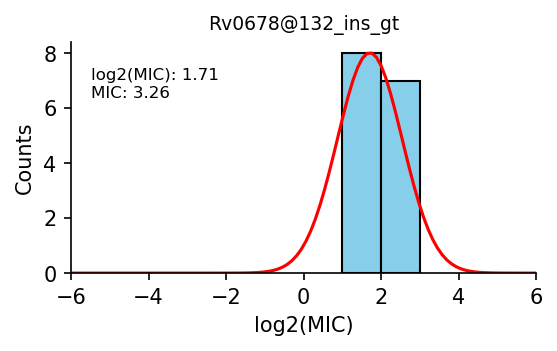

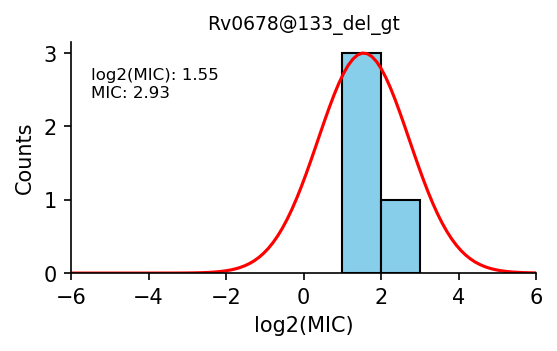

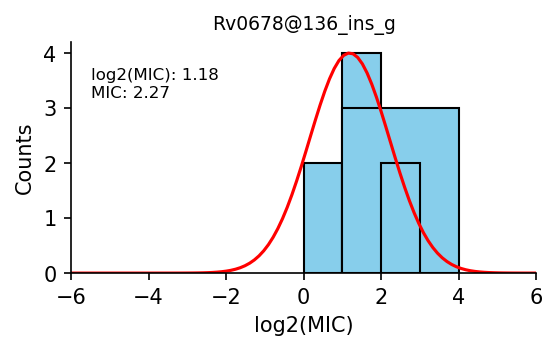

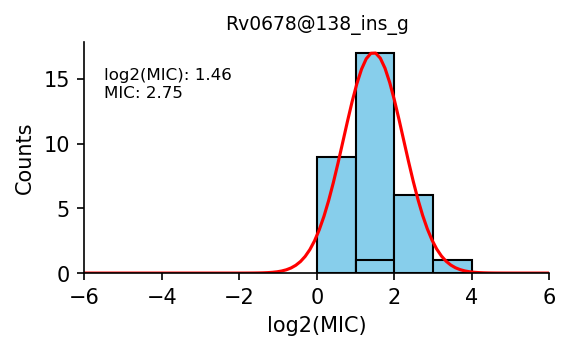

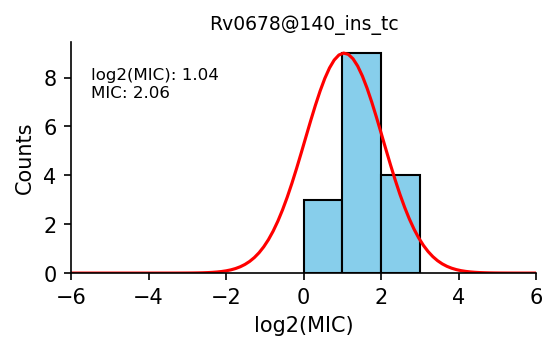

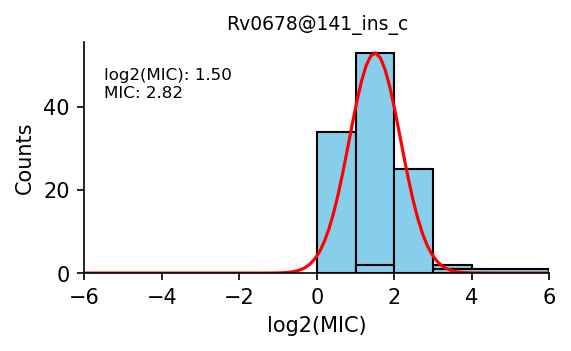

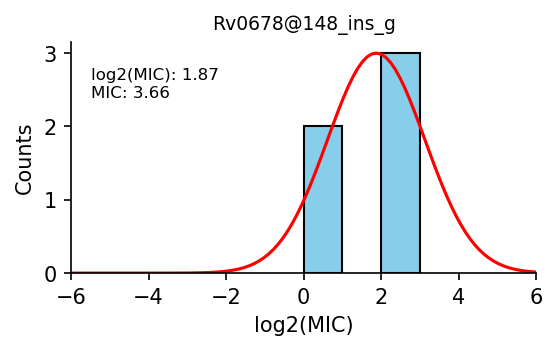

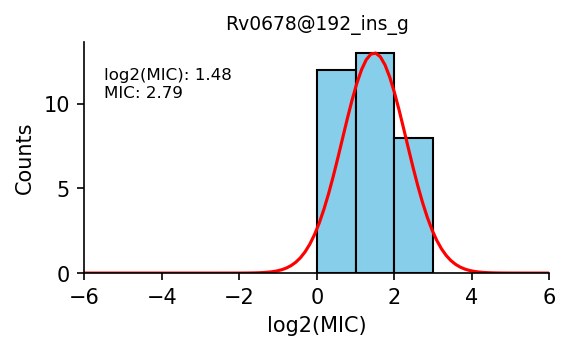

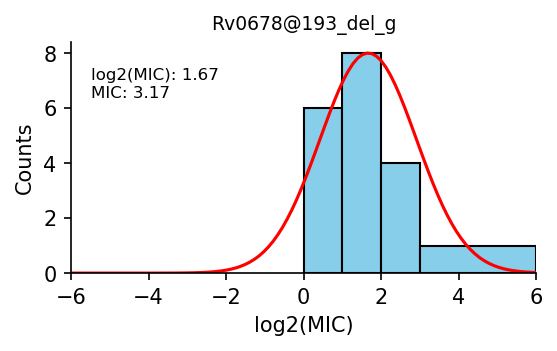

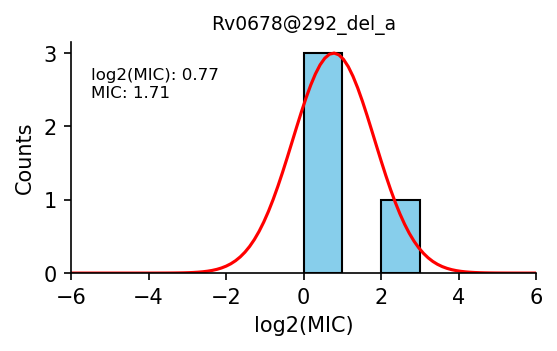

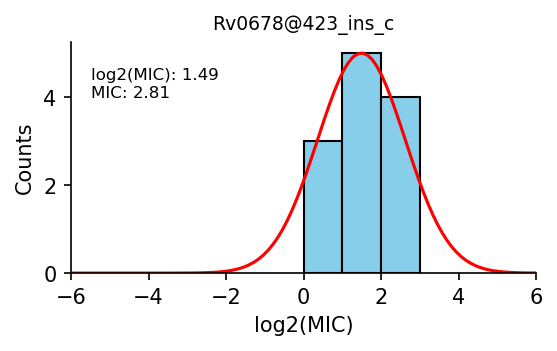

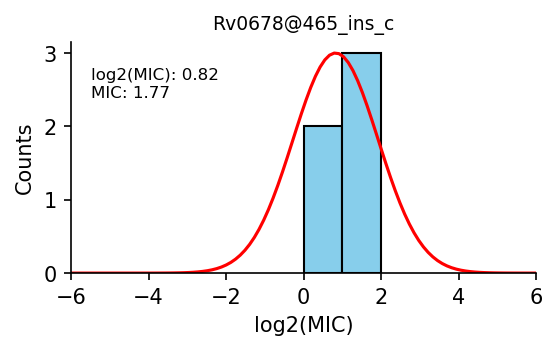

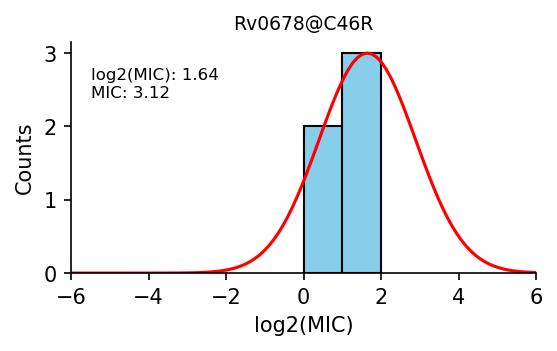

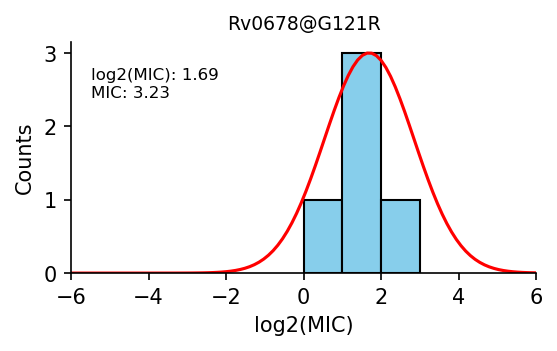

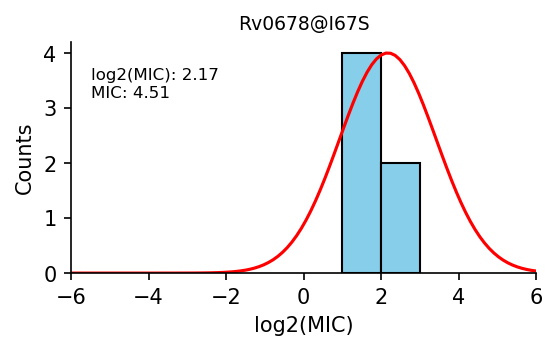

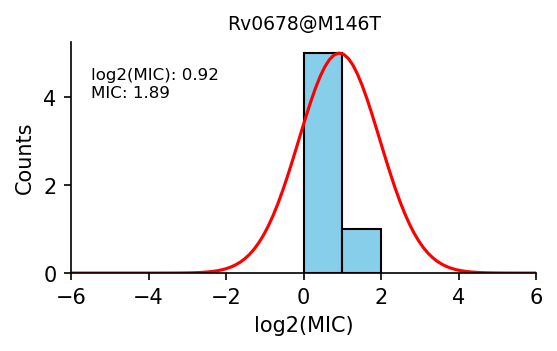

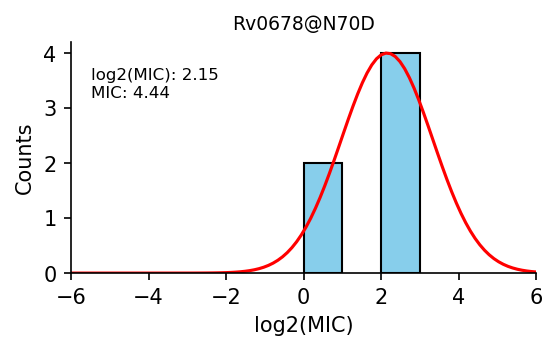

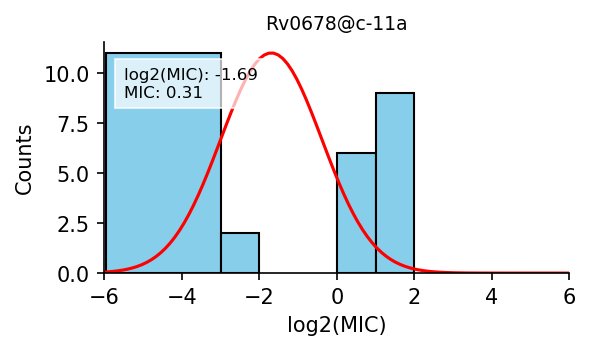

In [196]:
global_x_min = -6
global_x_max = 6

for _, row in w_wt_bfgs.iterrows():
    mutation_name = row['Mutation']
    log2_mic = row['Effect_Size']  # Assuming log2(MIC) is stored in 'Effect_Size'
    mic = row['MIC']  # Actual MIC value in the 'MIC' column

    if len(mut_y_low_log[mutation_name]) > 3:

        # Get the mutation-specific MIC intervals
        mutation_y_low_log = mut_y_low_log[mutation_name]
        mutation_y_high_log = mut_y_high_log[mutation_name]

        # Combine the low and high log2 MIC values into interval tuples for the current mutation
        mutation_intervals = [(low, high) for low, high in zip(mutation_y_low_log, mutation_y_high_log)]

        # Get unique intervals for the current mutation
        unique_intervals = sorted(set(mutation_intervals))

        # Calculate counts for each unique interval
        mutation_mic_counts = [mutation_intervals.count(interval) for interval in unique_intervals]

        # Extract the midpoints and widths for plotting the bars
        interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
        interval_widths = [high - low for low, high in unique_intervals]

        plt.figure(figsize=(4, 2))  # Create a new figure for each mutation
        
        # Step 1: Plot the histogram of calculated MIC intervals for this mutation
        plt.bar(interval_midpoints, height=mutation_mic_counts, width=interval_widths,
                align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

        # Step 2: Overlay the fitted normal distribution for the current mutation
        x_values = np.linspace(global_x_min, global_x_max, 100)
        
        # Generate the normal distribution using log2(MIC) (effect size) and std
        y_values = norm.pdf(x_values, loc=log2_mic, scale=row['Effect_Std'])
        
        # Scale the normal distribution to match the height of the histogram
        y_values *= max(mutation_mic_counts) / max(y_values)
        
        # Plot the fitted curve
        plt.plot(x_values, y_values, label=f'Fitted Curve for {mutation_name}', linestyle='-', color='red')
        
        # Add text annotation for log2(MIC) and MIC
        annotation_text = f"log2(MIC): {log2_mic:.2f}\nMIC: {mic:.2f}"
        plt.text(global_x_min + 0.5, max(mutation_mic_counts) * 0.8, annotation_text, fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='white', alpha=0.7))

        # Customize the plot
        plt.xlabel('log2(MIC)')
        plt.ylabel('Counts')
        plt.title(f'{mutation_name}', fontsize=9)  # Smaller font size
        plt.xlim([global_x_min, global_x_max])  # Set the consistent x-axis range
        
        # Remove top and right spines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show the plot for this mutation
        plt.show()


In [193]:
w_wt_bfgs

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_ins_a,-0.022719,1.039564,0.984376,0.709313
1,Rv0678@128_del_tgctggtgtg,0.722817,1.009063,1.650401,1.154338
2,Rv0678@128_del_tgctggtgtgt,0.707833,1.019495,1.633349,1.154223
3,Rv0678@130_del_ctggtgtgt,0.640644,1.040164,1.559025,1.124036
4,Rv0678@132_ins_gt,1.706248,0.837587,3.263110,1.894467
...,...,...,...,...,...
157,pepQ@Q5!,1.350117,1.027540,2.549327,1.815724
158,pepQ@S200L,1.065725,1.006561,2.093221,1.460430
159,pepQ@S66P,-4.360708,1.062429,0.048674,0.035844
160,pepQ@V102I,-2.553340,1.036860,0.170360,0.122437
